# Detecting Credit Card Fraud

Chris Sunderland

## Problem statement

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase. The dataset contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. The goal of this project is to build a model able to recognize fraudulent credit card transactions. More info [here](https://www.kaggle.com/mlg-ulb/creditcardfraud).

In [2]:
# load the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
from collections import defaultdict
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# EDA

In [2]:
pd.set_option('display.max_columns', None)

# read in the data
transactions_a = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectCCF/data/creditcard_a.csv")

transactions_b = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectCCF/data/creditcard_b.csv")

In [3]:
# combine the transactions data into 1 dataframe
transactions = pd.concat([transactions_a, transactions_b])

# inspect the first 5 rows
transactions.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# view 'transactions' df information
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284807 entries, 0 to 96545
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     284

In [5]:
# view summary statistics for the numerical field
transactions.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,1.673327e-15,-1.247012e-15,8.190001e-16,1.207294e-15,4.887456e-15,1.437716e-15,-3.772171e-16,9.564149e-16,1.039917e-15,6.406204e-16,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
# take a closer look at the columns that weren't transformed by PCA
transactions[['Time', 'Amount']].describe()


,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


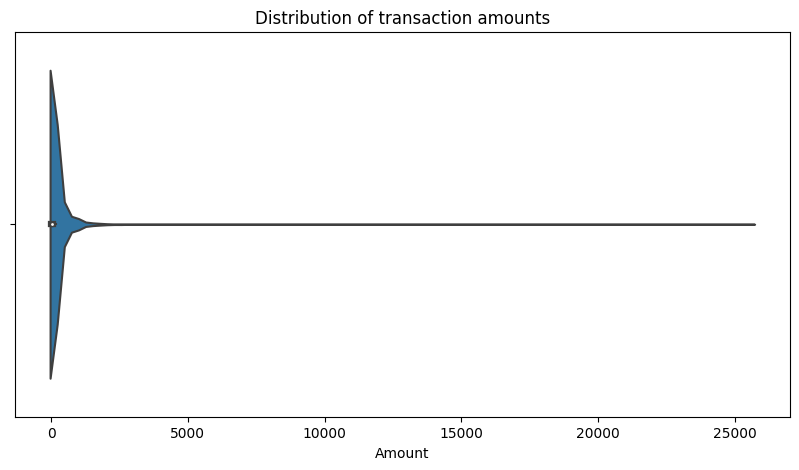

In [7]:
# view the spread of 'Amount'

plt.figure(figsize=(10,5))
plt.title('Distribution of transaction amounts')

sns.violinplot(x = transactions['Amount'])

plt.show()

In [8]:
# inspect the target variable 'Class'

total_normal = transactions['Class'].value_counts()[0]
total_fraud = transactions['Class'].value_counts()[1]

print("total non-fraudulent transactions: ", total_normal)
print("total fraudulent transactions: ", total_fraud)

percent_fraud =  (total_fraud / (total_normal + total_fraud))*100

print("percentage of transactions that are fraudulent: ", round(percent_fraud, 5))

total non-fraudulent transactions:  284315
total fraudulent transactions:  492
percentage of transactions that are fraudulent:  0.17275


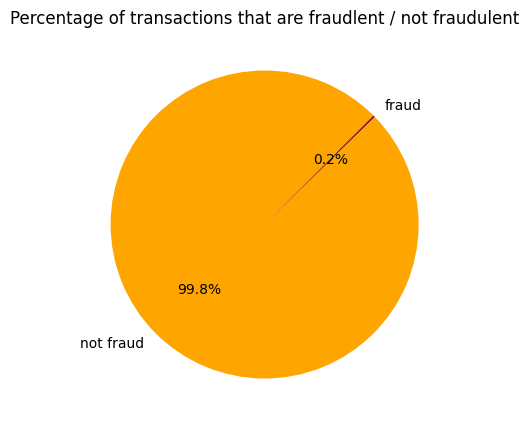

In [9]:
plt.figure(figsize=(5, 5))

plt.pie([total_normal, total_fraud], labels=['not fraud', 'fraud'], colors= ['#FFA500', '#8B0000'], 
        autopct='%1.1f%%', startangle=45)

plt.title('Percentage of transactions that are fraudlent / not fraudulent', fontsize=12)

plt.show()

In [10]:
# Are transactions with amount values in 75th percentile or above any more likely to be fraudulent?

cutoff_val_75th = transactions[['Amount']].describe().loc['75%'][0]
large_transactions = transactions[transactions['Amount'] > 77.165]

total_normal_75th = large_transactions['Class'].value_counts()[0]
total_fraud_75th = large_transactions['Class'].value_counts()[1]

percent_fraud_75th =  (total_fraud_75th / (total_normal_75th + total_fraud_75th))*100

print("percentage of fraudulent transactions: ", round(percent_fraud_75th, 5))


percentage of fraudulent transactions:  0.24438


## DATA PREPROCESSING

In [11]:
# check for missing values
transactions.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [12]:
# check for duplicate transactions
transactions.duplicated().sum()

1081

In [13]:
# remove duplicates
transactions.drop_duplicates(inplace=True)

In [14]:
# create feature set
X = transactions.iloc[:, :-1].copy()

y = transactions['Class']

In [15]:
# scale the values in the 'Amount' column
rs = RobustScaler()

X['Amount'] = rs.fit_transform(X['Amount'].to_numpy().reshape(-1,1))

In [16]:
# drop the 'Time' column from the feature set
X.drop('Time', inplace=True, axis=1)

In [17]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.774718
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.268530
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.959811
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.411487
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.667362


In [18]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, stratify= y, random_state=42)

# MODEL BUILDING

### Create functions to assist with the model-building (and evaluation) process

In [19]:
def compute_metrics(labels, predicted_labels):
    
    "function to compute a classifier's accuracy, f1 score, recall, and precision"
    
    accuracy = accuracy_score(labels, predicted_labels)
    f1 = f1_score(labels, predicted_labels)
    recall = recall_score(labels, predicted_labels)
    precision = precision_score(labels, predicted_labels)
    
    return accuracy, f1, recall, precision

In [20]:
def test_classifier(model, X_train, y_train, test_on= 'train'):
        
    """function that evaluates a classifier's baseline performance"""
    
    classifier = model
    print(type(classifier).__name__)
    
    start_time = time.time()
    
    classifier.fit(X_train, y_train)
        
    evaluation_set = test_on
    
    if evaluation_set == 'train':
        scores = compute_metrics(y_train, classifier.predict(X_train))
    else: 
        scores = compute_metrics(y_test, classifier.predict(X_test))
    
    finish_time = time.time()
    run_time = finish_time - start_time
    print(f"  run time = {round(run_time, 5)} seconds")
    
    classifier_summary = {'accuracy': scores[0],
                          'f1': scores[1],
                          'recall': scores[2],
                          'precision': scores[3]}
    
    return classifier_summary

In [21]:
def get_cv_scores(model, feature_set, labels, num_folds=3, sampling_technique=None):
        
    """
    function that calculates a classifier's cross-validated scores for several performance metrics
    if resampling technique is provided, the training instances in each fold are either over or under-sampled
    """
    
    classifier = model
    print(type(classifier).__name__)
    
    sf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    if sampling_technique is None:
        start_time = time.time()
        scores = cross_validate(model, feature_set, labels, cv=sf, scoring=['accuracy', 'f1', 'recall', 'precision'])
    else: 
        pipe = make_pipeline(sampling_technique, classifier)
        start_time = time.time()
        scores = cross_validate(pipe, feature_set, labels, cv=sf, scoring=['accuracy', 'f1', 'recall', 'precision'])
    
    finish_time = time.time()
    run_time = finish_time - start_time
    print(f"  run time = {round(run_time, 5)} seconds")
    
    accuracy_scores = scores['test_accuracy']
    f1_scores = scores['test_f1']
    recall_scores = scores['test_recall']
    precision_scores = scores['test_precision']
    
    classifier_summary = {'accuracy': accuracy_scores,
                          'f1': f1_scores,
                          'recall': recall_scores,
                          'precision': precision_scores}
    
    return classifier_summary

In [22]:
def model_loop(models_lst, X_train, y_train, model_type, test_on='train', cv=False, num_folds=None, sampler=None):
    
    """
    function that loops through a list of models and computes their scores using either the 'get_cv_scores'
    or 'test_classifier' function defined above
    """
    
    scores = defaultdict(float)

    for model in models_lst:
                    
        if cv is False and sampler is None: 
            # test model performance on the original training or test set
            scores[f"{type(model).__name__} {model_type}"] = test_classifier(model, X_train, y_train, test_on)
        elif cv is True and sampler is None: 
            # get model's cross-validated scores
            scores[f"{type(model).__name__} {model_type}"] = get_cv_scores(model, X_train, y_train, num_folds)
        else:
            # get model's cross-validated scores, resample the data in each fold
            scores[f"{type(model).__name__} {model_type}"] = get_cv_scores(model, X_train, y_train, 
                                                                           num_folds, sampler)
               
    summary_df = pd.DataFrame(scores).T.applymap(lambda x : np.mean(x))
    
    return scores, summary_df

In [23]:
def plot_cv_scores(model_scores, metric1, metric2):
   
    """function that create various boxplots displaying different models' cross-validated scores"""
    
    boxplot_df = pd.DataFrame.from_dict(model_scores, orient='index').stack().reset_index()
    boxplot_df.columns = ['model', 'metric', 'cv_score']
    
    boxplot_df = boxplot_df[(boxplot_df['metric'] == metric1) | 
                            (boxplot_df['metric'] == metric2)].reset_index(drop=True)
    boxplot_df = boxplot_df.explode('cv_score')
    
    sns.set_style('darkgrid')
    sns.set(font_scale=1.3)

    plt.figure(figsize=(16, 11))
    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1.1, .1))

    sns.boxplot(data=boxplot_df, x='model', y='cv_score', hue='metric')
    plt.xlabel('Model', size=20, labelpad=15)
    plt.ylabel('C-V Score', size=20, labelpad=15)
    plt.title('Classifiers\' cross-validated scores', size=22, pad=20)
    plt.legend(loc='upper left', fontsize='large')

    plt.show()

In [24]:
def plot_pr_curves(models_lst, X_train, y_train, X_test, y_test):
    
    """function to plot classifiers' precision-recall curves"""
    
    plt.figure(figsize=(10, 8))
    
    for model in models_lst:
        
        print("current model: ", type(model).__name__)
        model.fit(X_train, y_train)
        predicted_probs = model.predict_proba(X_test)[:, 1]
        prec, rec, _ = precision_recall_curve(y_test, predicted_probs)
        auc_pr = auc(rec, prec)

        plt.plot(rec, prec, label=f"{type(model).__name__} AUC: {round(auc_pr, 3)}")
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.show()

###  Fit models to the original, imbalanced training data to assess their baseline performance

#### Review performance on the training set

In [25]:
models = [AdaBoostClassifier(), BaggingClassifier(DecisionTreeClassifier()), DecisionTreeClassifier(), 
          KNeighborsClassifier(), LogisticRegression(solver='liblinear'), GaussianNB(), 
          RandomForestClassifier(max_depth=10), SGDClassifier(), XGBClassifier()]

_ , train_scores_df = model_loop(models, X_train, y_train, 'train baseline', test_on='train')

AdaBoostClassifier
  run time = 34.77277 seconds
BaggingClassifier
  run time = 59.87787 seconds
DecisionTreeClassifier
  run time = 8.54321 seconds
KNeighborsClassifier
  run time = 27.76708 seconds
LogisticRegression
  run time = 3.93151 seconds
GaussianNB
  run time = 0.33911 seconds
RandomForestClassifier
  run time = 74.50821 seconds
SGDClassifier
  run time = 0.69591 seconds
XGBClassifier
  run time = 10.40453 seconds


In [26]:
train_scores_df.sort_values(by='f1', ascending=False)

,accuracy,f1,recall,precision
DecisionTreeClassifier train baseline,1.000000,1.000000,1.000000,1.000000
XGBClassifier train baseline,1.000000,1.000000,1.000000,1.000000
BaggingClassifier train baseline,0.999924,0.976888,0.957704,0.996855
RandomForestClassifier train baseline,0.999738,0.914754,0.842900,1.000000
KNeighborsClassifier train baseline,0.999582,0.863262,0.791541,0.949275
AdaBoostClassifier train baseline,0.999295,0.779874,0.749245,0.813115
LogisticRegression train baseline,0.999250,0.739054,0.637462,0.879167
SGDClassifier train baseline,0.999169,0.701627,0.586103,0.873874
GaussianNB train baseline,0.977831,0.110325,0.824773,0.059117


#### Review performance on the test set

In [27]:
_, test_scores_df = model_loop(models, X_train, y_train, 'test baseline', test_on='test')

AdaBoostClassifier
  run time = 33.97483 seconds
BaggingClassifier
  run time = 60.15885 seconds
DecisionTreeClassifier
  run time = 8.99541 seconds
KNeighborsClassifier
  run time = 11.98099 seconds
LogisticRegression
  run time = 3.73557 seconds
GaussianNB
  run time = 0.20109 seconds
RandomForestClassifier
  run time = 68.38105 seconds
SGDClassifier
  run time = 0.62715 seconds
XGBClassifier
  run time = 9.54919 seconds


In [28]:
test_scores_df.sort_values(by='f1', ascending=False)

,accuracy,f1,recall,precision
RandomForestClassifier test baseline,0.999530,0.842520,0.753521,0.955357
XGBClassifier test baseline,0.999530,0.840000,0.739437,0.972222
KNeighborsClassifier test baseline,0.999448,0.811245,0.711268,0.943925
BaggingClassifier test baseline,0.999436,0.808000,0.711268,0.935185
AdaBoostClassifier test baseline,0.999166,0.732075,0.683099,0.788618
DecisionTreeClassifier test baseline,0.999048,0.717770,0.725352,0.710345
LogisticRegression test baseline,0.999095,0.675105,0.563380,0.842105
SGDClassifier test baseline,0.998990,0.616071,0.485915,0.841463
GaussianNB test baseline,0.977467,0.107907,0.816901,0.057769


###  Get the models cross-validated scores on the imbalanced dataset

In [29]:
model_cv_scores, model_cv_df = model_loop(models, X_train, y_train, model_type='imb', cv=True, num_folds=5)

AdaBoostClassifier
  run time = 132.67503 seconds
BaggingClassifier
  run time = 214.72158 seconds
DecisionTreeClassifier
  run time = 35.89716 seconds
KNeighborsClassifier
  run time = 23.72759 seconds
LogisticRegression
  run time = 11.71388 seconds
GaussianNB
  run time = 0.78807 seconds
RandomForestClassifier
  run time = 281.51844 seconds
SGDClassifier
  run time = 2.34621 seconds
XGBClassifier
  run time = 38.71597 seconds


In [30]:
# view the averages of cross-validated scores to see how the classifiers performed on the imbalanced dataset
model_cv_df.sort_values(by='f1', ascending=False)

,accuracy,f1,recall,precision
XGBClassifier imb,0.999567,0.859902,0.797693,0.933540
BaggingClassifier imb,0.999542,0.851115,0.788602,0.929493
RandomForestClassifier imb,0.999512,0.837207,0.755405,0.940517
KNeighborsClassifier imb,0.999476,0.828681,0.761556,0.910968
DecisionTreeClassifier imb,0.999194,0.765781,0.782587,0.754929
AdaBoostClassifier imb,0.999199,0.740447,0.686024,0.812825
LogisticRegression imb,0.999220,0.727048,0.625418,0.874404
SGDClassifier imb,0.999144,0.691052,0.577069,0.868503
GaussianNB imb,0.978077,0.111450,0.824830,0.059767


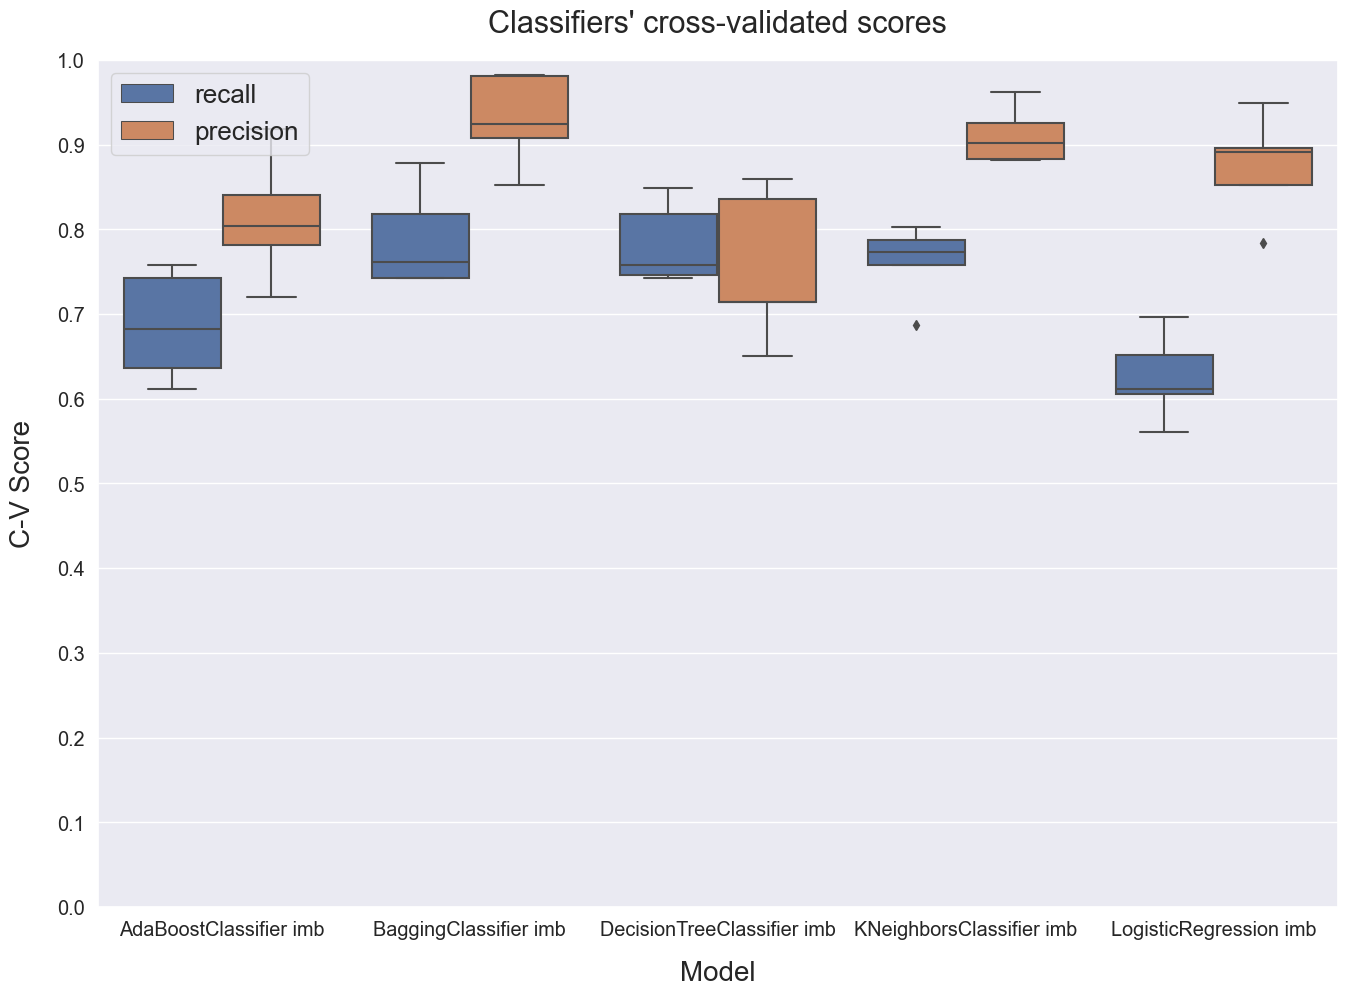

In [31]:
# plot the distribution of the classifiers' cross-validated recall and precision scores
plot1_data = {k: model_cv_scores[k] for k in list(model_cv_scores.keys())[:5]}
plot_cv_scores(plot1_data, 'recall', 'precision')


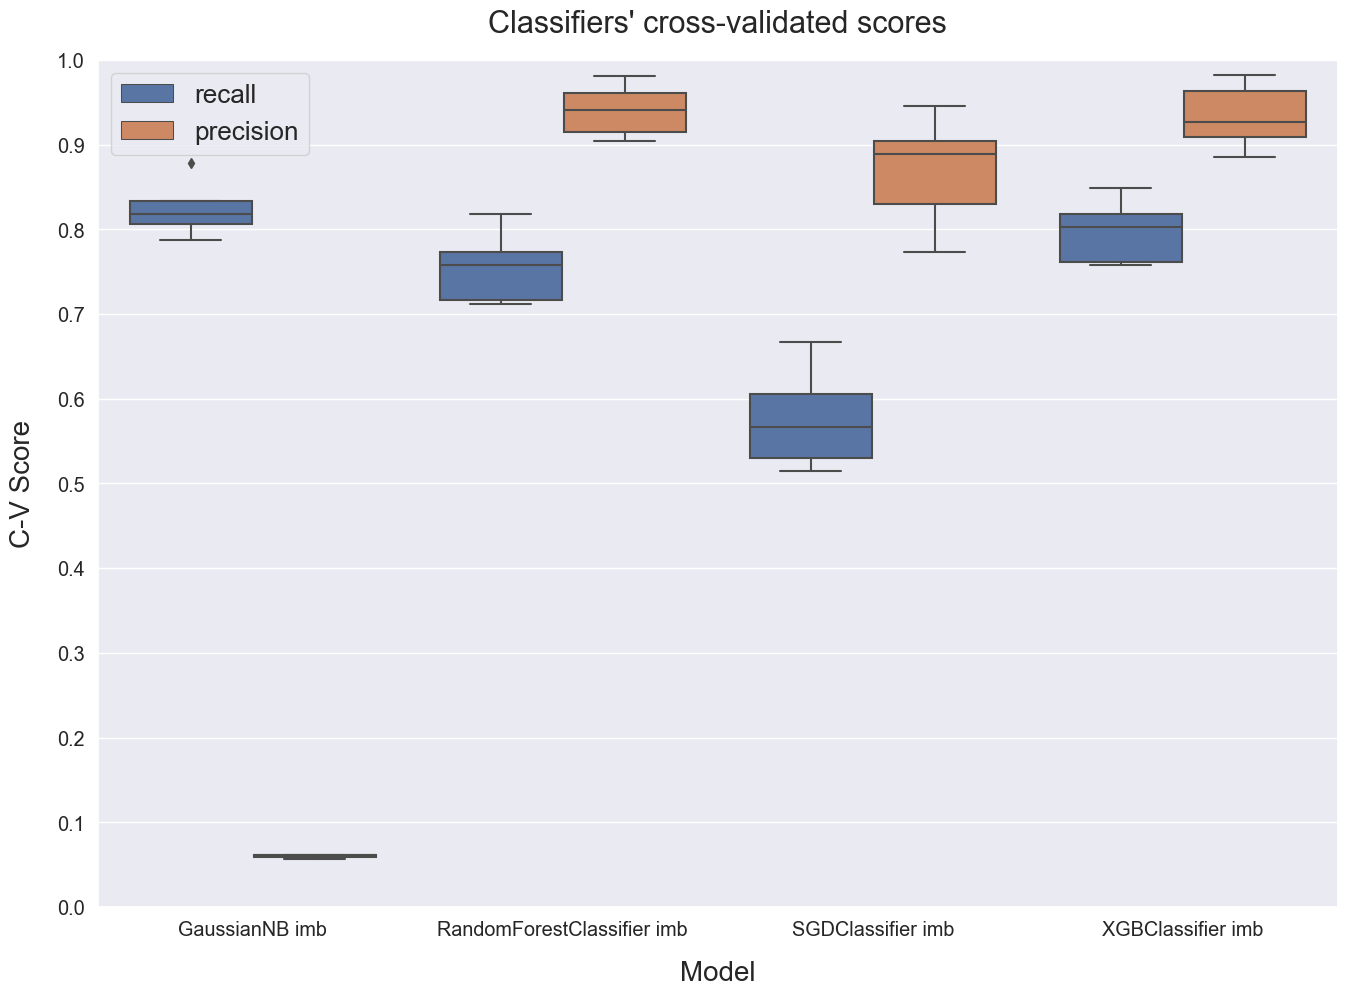

In [32]:
plot2_data = {k: model_cv_scores[k] for k in list(model_cv_scores.keys())[5:]}
plot_cv_scores(plot2_data, 'recall', 'precision')


current model:  AdaBoostClassifier
current model:  LogisticRegression
current model:  XGBClassifier


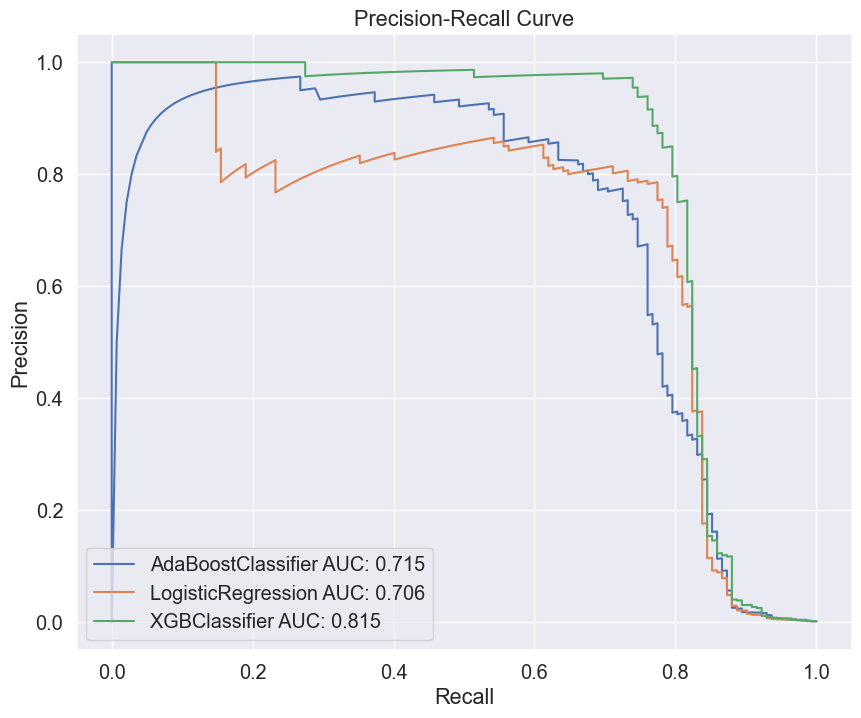

In [33]:
# plot precision-recall curves for a subset of the models

pr_models = [AdaBoostClassifier(), LogisticRegression(solver='liblinear'), XGBClassifier()]

plot_pr_curves(pr_models, X_train, y_train, X_test, y_test)

## SMOTE (Synthetic Minority Oversampling Technique)


### Compute the classifiers' cross-validated scores after applying SMOTE to different folds of the training data

In [34]:
model_sm_scores, model_sm_df = model_loop(models, X_train, y_train, 'cv smote', cv=True, 
                                          num_folds=5, sampler= SMOTE(random_state=42))

AdaBoostClassifier
  run time = 278.40137 seconds
BaggingClassifier
  run time = 524.50049 seconds
DecisionTreeClassifier
  run time = 85.5718 seconds
KNeighborsClassifier
  run time = 44.68941 seconds
LogisticRegression
  run time = 21.22752 seconds
GaussianNB
  run time = 3.09113 seconds
RandomForestClassifier
  run time = 507.04477 seconds
SGDClassifier
  run time = 7.31639 seconds
XGBClassifier
  run time = 698.76493 seconds


In [35]:
# add smote models' performance metrics to df storing previous results for the imbalanced data
combined_results = model_cv_df.copy()
combined_results = pd.concat([combined_results, model_sm_df])

In [36]:
model_sm_df.sort_values(by='f1', ascending=False)

,accuracy,f1,recall,precision
XGBClassifier cv smote,0.999376,0.817455,0.836952,0.799528
BaggingClassifier cv smote,0.998897,0.708739,0.800633,0.636915
RandomForestClassifier cv smote,0.998636,0.676489,0.846043,0.565551
KNeighborsClassifier cv smote,0.997961,0.581218,0.846133,0.443714
DecisionTreeClassifier cv smote,0.997488,0.512850,0.791542,0.379877
AdaBoostClassifier cv smote,0.982649,0.146913,0.894527,0.080073
GaussianNB cv smote,0.975364,0.105046,0.867164,0.055916
LogisticRegression cv smote,0.972544,0.099803,0.909453,0.052814
SGDClassifier cv smote,0.970605,0.097859,0.909408,0.051865


## RandomUnderSampler

### Compute classifiers' c-v scores after applying RandomUnderSampler to different folds of the training data

In [37]:
rus_model_scores, rus_model_df = model_loop(models, X_train, y_train, 'cv RUS', 
                                         cv=True, num_folds=5, sampler= RandomUnderSampler(random_state=42))

AdaBoostClassifier
  run time = 1.98873 seconds
BaggingClassifier
  run time = 0.89242 seconds
DecisionTreeClassifier
  run time = 0.48265 seconds
KNeighborsClassifier
  run time = 4.61275 seconds
LogisticRegression
  run time = 0.63808 seconds
GaussianNB
  run time = 0.54676 seconds
RandomForestClassifier
  run time = 2.0208 seconds
SGDClassifier
  run time = 0.62516 seconds
XGBClassifier
  run time = 0.87852 seconds


In [38]:
# update the results df once again
combined_results = pd.concat([combined_results, rus_model_df])

In [39]:
rus_model_df.sort_values(by='f1', ascending=False)

,accuracy,f1,recall,precision
KNeighborsClassifier cv RUS,0.974085,0.106549,0.888467,0.056836
RandomForestClassifier cv RUS,0.973425,0.103725,0.903483,0.055081
GaussianNB cv RUS,0.966331,0.080086,0.864134,0.042029
XGBClassifier cv RUS,0.960581,0.074044,0.918634,0.038624
BaggingClassifier cv RUS,0.960727,0.073289,0.912573,0.038204
LogisticRegression cv RUS,0.960007,0.072896,0.918498,0.037996
AdaBoostClassifier cv RUS,0.949765,0.057552,0.918544,0.029710
SGDClassifier cv RUS,0.936307,0.046474,0.927589,0.023837
DecisionTreeClassifier cv RUS,0.904098,0.031639,0.921529,0.016101


## WEIGHTED CLASSIFICATION

### Test how the relevant classifiers perform after adjusting the class weights

In [40]:
# have a larger penalty for not detecting class 1 (false negatives)

fraud_nonfraud_ratio = y_train.value_counts()[1] / y_train.value_counts()[0]

nonfraud_fraud_ratio = np.floor(y_train.value_counts()[0] /  y_train.value_counts()[1]).astype(int)

weights = {0: fraud_nonfraud_ratio, 1:1}

weighted_models = [BaggingClassifier(DecisionTreeClassifier(class_weight = weights)), 
                   DecisionTreeClassifier(class_weight = weights),
                   LogisticRegression(solver='liblinear', class_weight='balanced'),
                   RandomForestClassifier(max_depth=10, class_weight= weights), 
                   SGDClassifier(class_weight= weights),
                   XGBClassifier(scale_pos_weight = nonfraud_fraud_ratio)]


In [41]:
weighted_model_scores, weighted_model_df = model_loop(weighted_models, X_train, y_train, 'cv weighted', 
                                                      cv=True, num_folds=5)

BaggingClassifier
  run time = 104.12479 seconds
DecisionTreeClassifier
  run time = 18.42945 seconds
LogisticRegression
  run time = 12.87277 seconds
RandomForestClassifier
  run time = 204.83667 seconds
SGDClassifier
  run time = 2.51908 seconds
XGBClassifier
  run time = 45.75663 seconds


In [42]:
combined_results = pd.concat([combined_results, weighted_model_df])

In [43]:
weighted_model_df.sort_values(by='f1', ascending=False)

,accuracy,f1,recall,precision
XGBClassifier cv weighted,0.999567,0.864895,0.830891,0.902257
RandomForestClassifier cv weighted,0.999466,0.834188,0.803709,0.867730
BaggingClassifier cv weighted,0.999507,0.833328,0.740163,0.953594
DecisionTreeClassifier cv weighted,0.999089,0.725443,0.721800,0.730797
SGDClassifier cv weighted,0.978374,0.126934,0.894437,0.068566
LogisticRegression cv weighted,0.973606,0.103266,0.906513,0.054778


# MODEL EVALUATION

In [44]:
# review top-performing models
combined_results[combined_results['f1'] > .75].sort_values(by='recall', ascending=False).head(10)

,accuracy,f1,recall,precision
XGBClassifier cv smote,0.999376,0.817455,0.836952,0.799528
XGBClassifier cv weighted,0.999567,0.864895,0.830891,0.902257
RandomForestClassifier cv weighted,0.999466,0.834188,0.803709,0.867730
XGBClassifier imb,0.999567,0.859902,0.797693,0.933540
BaggingClassifier imb,0.999542,0.851115,0.788602,0.929493
DecisionTreeClassifier imb,0.999194,0.765781,0.782587,0.754929
KNeighborsClassifier imb,0.999476,0.828681,0.761556,0.910968
RandomForestClassifier imb,0.999512,0.837207,0.755405,0.940517
BaggingClassifier cv weighted,0.999507,0.833328,0.740163,0.953594


## Hyper-parameter tuning

In [45]:
# GRID SEARCH 1: SMOTE + XG BOOST

sf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

pipe = make_pipeline(SMOTE(random_state=42), XGBClassifier(random_state=42))

params = {'xgbclassifier__n_estimators': [100, 300],
          'xgbclassifier__max_depth': [3, 6]}

gs1 = GridSearchCV(pipe,
                   param_grid= params,
                   cv= sf,
                   scoring='f1',
                   n_jobs=-1,
                   verbose= True)

start_time = time.time()

gs1.fit(X_train, y_train)

finish_time = time.time()

run_time = finish_time - start_time

print(run_time, " seconds")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
621.8190820217133  seconds


In [46]:
gs1.best_params_

{'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimators': 300}

In [47]:
# see how the best estimator performs on the test set 
gs1_model = gs1.best_estimator_
gs1_model_test_pred = gs1_model.predict(X_test)
print(classification_report(y_test, gs1_model_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.84      0.79      0.81       142

    accuracy                           1.00     85118
   macro avg       0.92      0.89      0.91     85118
weighted avg       1.00      1.00      1.00     85118



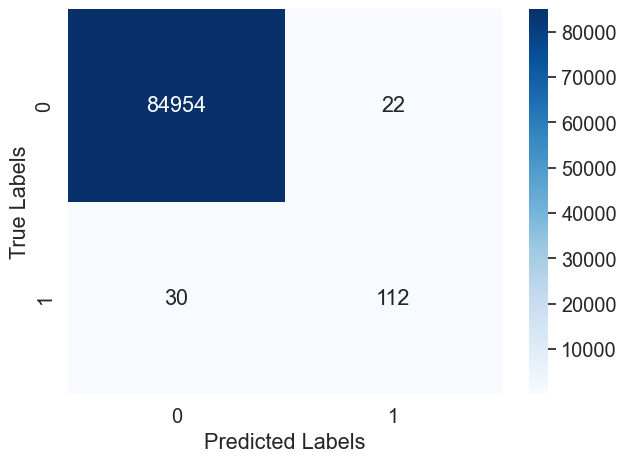

In [48]:
# confusion matrix for GS1 best estimator's performance on the test set
gs1_test_cm = confusion_matrix(y_test, gs1_model_test_pred)

plt.figure(figsize=(7,5))

sns.heatmap(gs1_test_cm, annot=True, fmt='d', cmap="Blues")

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [54]:
# view the features that the model deemed to be most important

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

xgb_model = XGBClassifier(n_estimators=300, max_depth=6).fit(X_train_sm, y_train_sm)

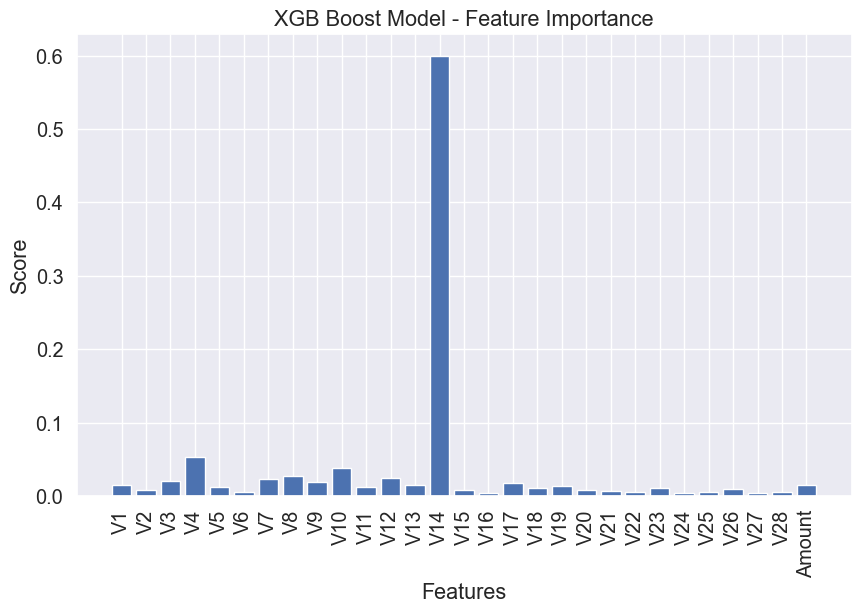

In [63]:
xgb_feat_importances = xgb_model.feature_importances_

plt.figure(figsize=(10, 6))

plt.bar(range(len(xgb_feat_importances)), xgb_feat_importances)

plt.xticks(range(len(xgb_feat_importances)), X_train_sm.columns, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Score')
plt.title('XGB Boost Model - Feature Importance')
plt.show()

In [64]:
# GRID SEARCH 2: RANDOM FOREST

params = {'n_estimators': [100, 200, 300], 
          'max_depth': [5, 10]}

gs2 = GridSearchCV(RandomForestClassifier(class_weight= weights),
                   param_grid= params,
                   cv= sf,
                   scoring='recall',
                   verbose= True)

start_time = time.time()

gs2.fit(X_train, y_train)

finish_time = time.time()

run_time = finish_time - start_time

print(run_time, " seconds")


Fitting 3 folds for each of 6 candidates, totalling 18 fits
1674.679074048996  seconds


In [68]:
gs2.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [69]:
gs2_model = gs2.best_estimator_
gs2_model_test_pred = gs2_model.predict(X_test)
print(classification_report(y_test, gs2_model_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.44      0.80      0.57       142

    accuracy                           1.00     85118
   macro avg       0.72      0.90      0.78     85118
weighted avg       1.00      1.00      1.00     85118



In [70]:
# SAVE THE BEST MODEL - TUNED XG BOOST WITH SMOTE 

with open('fraud_detection_model.pkl', 'wb') as file:    
    pickle.dump(gs1_model, file)
    